##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [1]:
%pip install -U -q "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 2.9 MB/s eta 0:00:00


To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [2]:
# Used to securely store your API key
from google.colab import userdata
from google import genai
API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) from the open-source [SciKit project](https://scikit-learn.org/) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [3]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [4]:
idx = newsgroups_train.data[0].index("Lines")
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
import re

# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [
    re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in newsgroups_train.data
]  # Remove email
newsgroups_train.data = [
    re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data
]  # Remove names
newsgroups_train.data = [
    d.replace("From: ", "") for d in newsgroups_train.data
]  # Remove "From: "
newsgroups_train.data = [
    d.replace("\nSubject: ", "") for d in newsgroups_train.data
]  # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [
    d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data
]

In [6]:
import pandas as pd

# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=["Text"])
df_train["Label"] = newsgroups_train.target
# Match label to target name index
df_train["Class Name"] = df_train["Label"].map(
    newsgroups_train.target_names.__getitem__
)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [7]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (
    df_train.groupby("Label", as_index=False)
    .apply(lambda x: x.sample(SAMPLE_SIZE))
    .reset_index(drop=True)
)

# Choose categories about science
df_train = df_train[df_train["Class Name"].str.contains("sci")]

# Reset the index
df_train = df_train.reset_index()
df_train

<ipython-input-7-dc22d2141534>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,Re: White House Public Encryption Management ...,11,sci.crypt
1,1651,Re: The [secret] source of that announcement\...,11,sci.crypt
2,1652,Re: text of White House announcement and Q&As...,11,sci.crypt
3,1653,Re: White House Wiretap Chip Disinformation S...,11,sci.crypt
4,1654,Tony Lezard <>Re: text of White House announce...,11,sci.crypt
...,...,...,...,...
595,2245,Leigh Palmer <>Re: Orion drive in vacuum -- ho...,14,sci.space
596,2246,Re: A WRENCH in the works?\nOrganization: Ken...,14,sci.space
597,2247,Re: space news from Feb 15 AW&ST\nOrganizatio...,14,sci.space
598,2248,Subject: DC-X/Y/1 question\n \nKeywords: DC-X\...,14,sci.space


In [8]:
df_train["Class Name"].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the embeddings model, `text-embedding-004`, there is a task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These parameters apply only to the embeddings models. The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [9]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math


def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLUSTERING and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001","text-embedding-004"] {allow-input: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df


df_train = create_embeddings(df_train)
df_train.drop("index", axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [10]:
len(df_train["Embeddings"][0])

768

In [11]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [13]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["Class Name"] = df_train[
    "Class Name"
]  # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-21.515207,4.553598,sci.crypt
1,-15.827778,-8.150129,sci.crypt
2,-24.811195,5.841414,sci.crypt
3,-23.533512,6.998471,sci.crypt
4,-23.327581,2.978018,sci.crypt
...,...,...,...
595,13.261472,-28.758375,sci.space
596,4.294526,-32.239464,sci.space
597,27.036417,-18.934540,sci.space
598,4.773326,-21.166903,sci.space


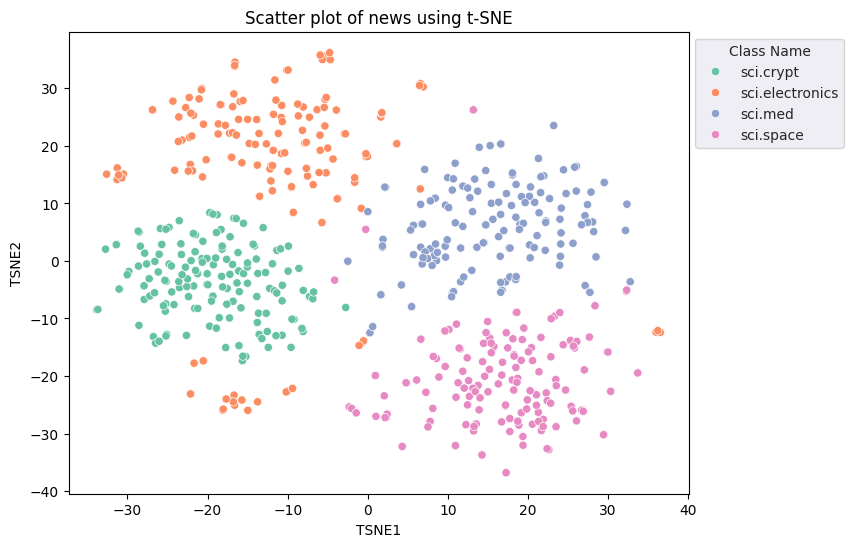

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [15]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby("Class Name").mean()
    return centroids


centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-19.444420,-3.684580
sci.electronics,-11.396699,15.218337
sci.med,15.847226,5.903560
sci.space,16.557491,-20.563791


In [16]:
def get_embedding_centroids(df):
    emb_centroids = dict()
    grouped = df.groupby("Class Name")
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        # Get the centroid value of dimension 768
        emb_centroids[c] = np.mean(sub_df["Embeddings"], axis=0)

    return emb_centroids

In [17]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

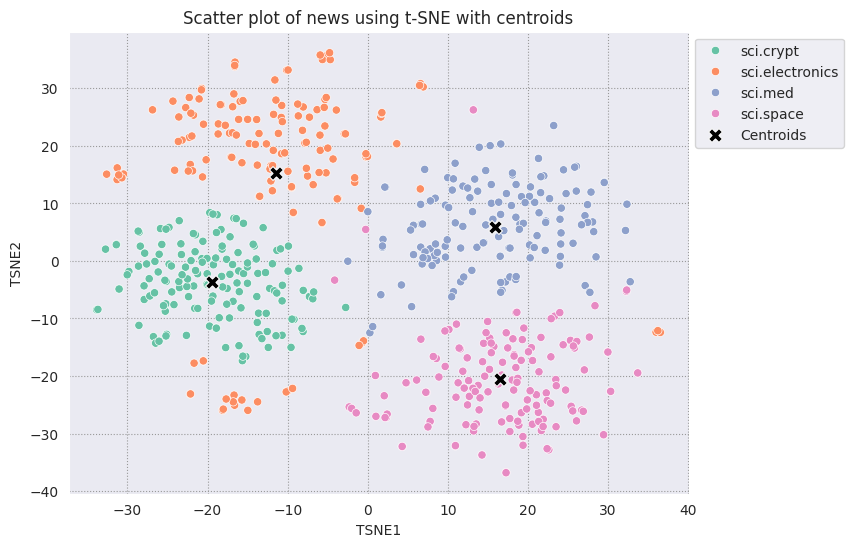

In [18]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE with centroids")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [19]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))


def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row["Class Name"]  # Get class name of row
        # Compare centroid distances
        dist = calculate_euclidean_distance(
            row["Embeddings"], emb_centroids[class_name]
        )
        df.at[idx, "Outlier"] = dist > radius

    return len(df[df["Outlier"] == True])

In [20]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(df_train, emb_c, i))

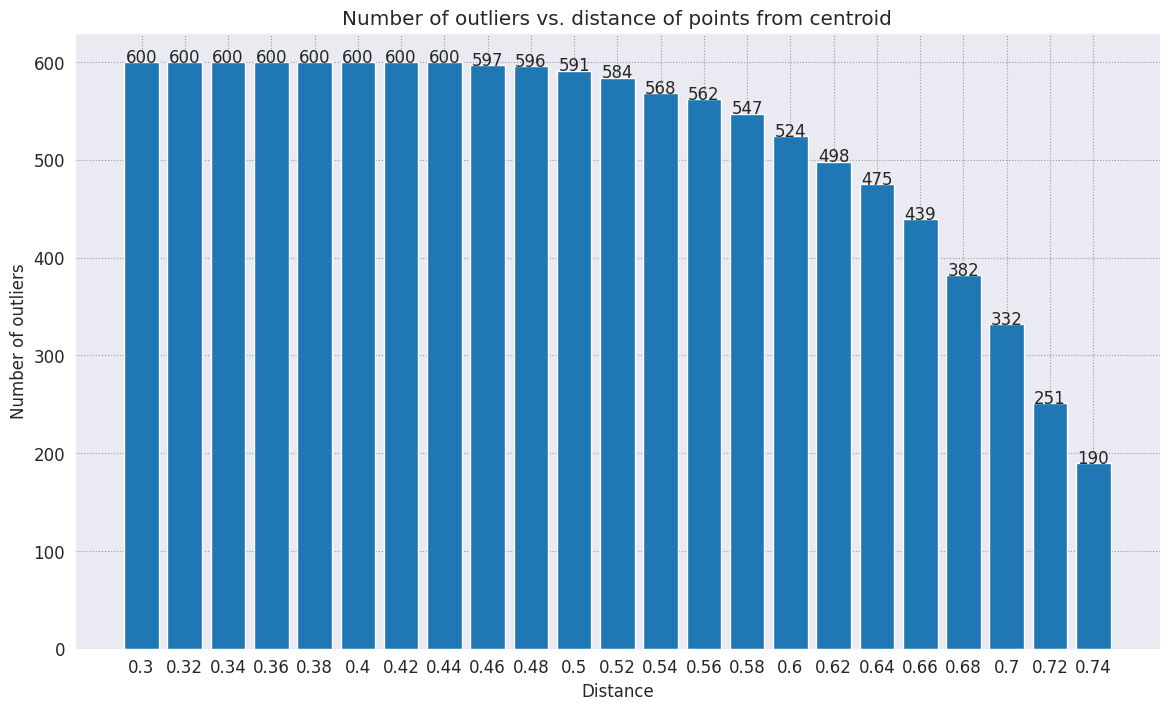

In [21]:
# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha="center")

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [22]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train["Outlier"] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
1,Re: The [secret] source of that announcement\...,11,sci.crypt,"[0.027169958, 0.0180854, -0.079990745, 0.01548...",True
3,Re: White House Wiretap Chip Disinformation S...,11,sci.crypt,"[0.011647083, 0.006911768, -0.028479766, 0.034...",True
5,Re: Why the clipper algorithm is secret\nOrga...,11,sci.crypt,"[0.021074744, 0.08058417, 0.0095778825, 0.0386...",True
6,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,"[0.03491447, 0.023669688, -0.049023017, 0.0275...",True
9,Graham Toal <>Re: The battle is joined\nOrigin...,11,sci.crypt,"[0.05105832, -0.009382685, -0.035797328, 0.016...",True


In [23]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers["Outlier"].index]

Plot the outliers and denote them using a transparent red color.

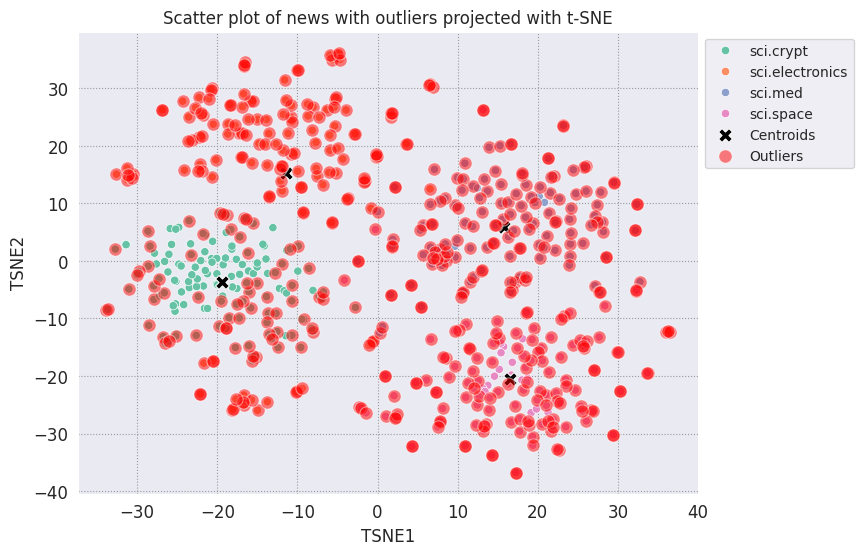

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
plt.rcParams.update({"font.size": 10})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
# Draw a red circle around the outliers
sns.scatterplot(
    data=outliers_projected,
    x="TSNE1",
    y="TSNE2",
    color="red",
    marker="o",
    alpha=0.5,
    s=90,
    label="Outliers",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news with outliers projected with t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [25]:
sci_crypt_outliers = df_outliers[df_outliers["Class Name"] == "sci.crypt"]
print(sci_crypt_outliers["Text"].iloc[0])

 Re: The [secret] source of that announcement
Organization: DSI/USCRPAC
Lines: 23


 suggests using a common but restricted-distribution private
key to allow public key system encrypted postings. In theory that will work
fine as long as the privae key remains secure.

In practice it would be a good idea to check to see if that would be a
violation of some net rule, practice, custom, etc. I don't say it would be,
just that it would be a good idea to check. This is not like rot13 where
everybody can have the key trivially.

It would also be a good idea to check to see if such posts would be
forwarded by the sites needed to make the chain work.

Of course there'd be no problem with a discussion group travelling over
facilities entirely under the control of the members. Probably there would
also be no problem with a mailing list approach. It might even  be fun for
some.

-- 
David Sternlight         Great care has been taken to ensure the accuracy of
                         our informatio

In [26]:
sci_elec_outliers = df_outliers[df_outliers["Class Name"] == "sci.electronics"]
print(sci_elec_outliers["Text"].iloc[0])

 Re: arcade style buttons and joysticks
Organization: Antone's Italian Kitchen and Excellence in Operating Network
X-Newsreader: rusnews v1.02
Lines: 26

  writes:

> Hi there,
> Can anyone tell me where it is possible to purchase controls found
> on most arcade style games.  Many projects I am working on would
> be greatly augmented if I could implement them.  Thanx in advance.
> 
> -Dave
> 
> 

Contact Chris Arthur at 
He restores lots of old video and arcade games and knows where to get
parts.

Tony

-----------------------------------------------------------------------
-- Anthony S. Pelliccio, kd1nr/ae    // Yes, you read it right, the  //
-- system @ garlic.sbs.com          // man who went from No-Code    //
-----------------------------------//  to Extra in     //
-- Flame Retardent Sysadmin       // exactly one year!            //
-------------------------------------------------------------------
-- This is a calm .sig! --
--------------------------




In [27]:
sci_med_outliers = df_outliers[df_outliers["Class Name"] == "sci.med"]
print(sci_med_outliers["Text"].iloc[0])

 Re: Is MSG sensitivity superstition?
Organization: your service
Lines: 20
NNTP-Posting-Host: hpctdkz.col.hp.com


Jason Chen writes:
> Now here is a new one: vomiting. My guess is that MSG becomes the number one
> suspect of any problem. In this case. it might be just food poisoning. But
> if you heard things about MSG, you may think it must be it.

----------

Yeah, it might, if you only read the part you quoted.  You somehow left 
out the part about "we all ate the same thing."  Changes things a bit, eh?

You complain that people blame MSG automatically, since it's an unknown and
therefore must be the cause.  It is equally  unreasonable to
defend it, automatically assuming that it CAN'T be the culprit.

Pepper makes me sneeze.  If it doesn't affect you the same way, fine.
Just don't tell me I'm wrong for saying so.

These people aren't condemning Chinese food, Mr. Chen - just one of its 
 ingredients.  Try not to take it so personally.



In [28]:
sci_space_outliers = df_outliers[df_outliers["Class Name"] == "sci.space"]
print(sci_space_outliers["Text"].iloc[0])

 Re: Abyss--breathing fluids
Organization: U.C. Berkeley Math. Department.
Lines: 19
NNTP-Posting-Host: skippy.berkeley.edu

Are breathable liquids possible?

I remember seeing an old Nova or The Nature of Things where this idea was
touched upon .  If nothing else, I know
such liquids ARE possible because...

They showed a large glass full of this liquid, and put a white mouse  in
it.  Since the liquid was not dense, the mouse would float, so it was held down
by tongs clutching its tail.  The thing struggled quite a bit, but it was
certainly held down long enough so that it was breathing the liquid.  It never
did slow down in its frantic attempts to swim to the top.

Now, this may not have been the most humane of demonstrations, but it certainly
shows breathable liquids can be made.
-- 
*Isaac Kuo 	*       ___
*					* _____/_o_\_____
*	Twinkle, twinkle, little .sig,	*(====)
*	Keep it less than 5 lines big.	* \==\/     \/==/



## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).